In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo


In [2]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : isol.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : isol.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : isol.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [4]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [5]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [6]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))


In [7]:
#Load Predictor
predictor_path = '../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')

predictor.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 205, 4, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 198, 1, 96)   3168        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 99, 1, 96)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 94, 1, 128)   73856       max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [8]:
#APARENT parameters
seq_input_shape = (1, 205, 4)
lib_input_shape = (13,)
distal_pas_shape = (1,)
num_outputs_iso = 1
num_outputs_cut = 206

#Shared model definition
layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu')
layer_1_pool = MaxPooling2D(pool_size=(2, 1))
layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu')
layer_dense = Dense(256, activation='relu')
layer_drop = Dropout(0.2)

def shared_model(seq_input, distal_pas_input) :
    return layer_drop(
        layer_dense(
            Concatenate()([
                Flatten()(
                    layer_2(
                        layer_1_pool(
                            layer_1(
                                seq_input
                            )
                        )
                    )
                ),
                distal_pas_input
            ])
        )
    )

#Inputs
seq_input = Input(shape=seq_input_shape)
lib_input = Input(shape=lib_input_shape)
distal_pas_input = Input(shape=distal_pas_shape)

permute_layer = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1)))

plasmid_out_shared = Concatenate()([shared_model(permute_layer(seq_input), distal_pas_input), lib_input])

plasmid_out_cut = Dense(num_outputs_cut, activation='softmax', kernel_initializer='zeros')(plasmid_out_shared)
plasmid_out_iso = Dense(num_outputs_iso, activation='linear', kernel_initializer='zeros')(plasmid_out_shared)

predictor_temp = Model(
    inputs=[
        seq_input,
        lib_input,
        distal_pas_input
    ],
    outputs=[
        plasmid_out_iso,
        plasmid_out_cut
    ]
)

predictor_temp.load_weights('../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5')

predictor = Model(
    inputs=predictor_temp.inputs,
    outputs=[
        predictor_temp.outputs[0]
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


In [9]:
#Feature substitution, sequences

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

perturb_scores_test = np.zeros(x_test.shape)

y_hat_ref = predictor.predict([x_test, aparent_l_test, aparent_d_test], batch_size=32, verbose=True)[:, 0]

aparent_l_var = np.zeros((x_test.shape[2] * x_test.shape[3], 13))
aparent_l_var[:, 4] = 1.

aparent_d_var = np.ones((x_test.shape[2] * x_test.shape[3], 1))

for data_ix in range(x_test.shape[0]) :
    
    if data_ix % 100 == 0 :
        print("Processing example " + str(data_ix) + "...")
    
    x = x_test[data_ix, :, :, :]
    x_var = np.zeros((x.shape[1] * x.shape[2], 1, x.shape[1], x.shape[2]))
    
    x_var[:, :, :, :] = x[:, :, :]
    
    for j in range(x_test.shape[2]) :
        for k in range(x_test.shape[3]) :
            x_var[j * x_test.shape[3] + k, 0, j, :] = 0.
            x_var[j * x_test.shape[3] + k, 0, j, k] = 1.
    
    y_hat_var = predictor.predict([x_var, aparent_l_var, aparent_d_var], batch_size=32)[:, 0]
    
    for j in range(x_test.shape[2]) :
        for k in range(x_test.shape[3]) :
            perturb_scores_test[data_ix, 0, j, k] = y_hat_var[j * x_test.shape[3] + k] - y_hat_ref[data_ix]


54/54 [==============================] - 0s 9ms/step
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...


In [10]:
'''
#Feature substitution, sequences

x_test = np.transpose(x_test, (0, 2, 3, 1))

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

perturb_scores_test = np.zeros(x_test.shape)

y_hat_ref = predictor.predict([x_test, aparent_l_test, aparent_d_test], batch_size=32, verbose=True)[:, 0]

aparent_l_var = np.zeros((x_test.shape[1] * x_test.shape[2], 13))
aparent_l_var[:, 4] = 1.

aparent_d_var = np.ones((x_test.shape[1] * x_test.shape[2], 1))

for data_ix in range(x_test.shape[0]) :
    
    if data_ix % 100 == 0 :
        print("Processing example " + str(data_ix) + "...")
    
    x = x_test[data_ix, :, :, :]
    x_var = np.zeros((x.shape[0] * x.shape[1], x.shape[0], x.shape[1], 1))
    
    x_var[:, :, :, :] = x[:, :, :]
    
    for j in range(x_test.shape[1]) :
        for k in range(x_test.shape[2]) :
            x_var[j * x_test.shape[2] + k, j, :, 0] = 0.
            x_var[j * x_test.shape[2] + k, j, k, 0] = 1.
    
    y_hat_var = predictor.predict([x_var, aparent_l_var, aparent_d_var], batch_size=32)[:, 0]
    
    for j in range(x_test.shape[1]) :
        for k in range(x_test.shape[2]) :
            perturb_scores_test[data_ix, j, k, 0] = y_hat_var[j * x_test.shape[2] + k] - y_hat_ref[data_ix]

'''

'\n#Feature substitution, sequences\n\nx_test = np.transpose(x_test, (0, 2, 3, 1))\n\naparent_l_test = np.zeros((x_test.shape[0], 13))\naparent_l_test[:, 4] = 1.\n\naparent_d_test = np.ones((x_test.shape[0], 1))\n\nperturb_scores_test = np.zeros(x_test.shape)\n\ny_hat_ref = predictor.predict([x_test, aparent_l_test, aparent_d_test], batch_size=32, verbose=True)[:, 0]\n\naparent_l_var = np.zeros((x_test.shape[1] * x_test.shape[2], 13))\naparent_l_var[:, 4] = 1.\n\naparent_d_var = np.ones((x_test.shape[1] * x_test.shape[2], 1))\n\nfor data_ix in range(x_test.shape[0]) :\n    \n    if data_ix % 100 == 0 :\n        print("Processing example " + str(data_ix) + "...")\n    \n    x = x_test[data_ix, :, :, :]\n    x_var = np.zeros((x.shape[0] * x.shape[1], x.shape[0], x.shape[1], 1))\n    \n    x_var[:, :, :, :] = x[:, :, :]\n    \n    for j in range(x_test.shape[1]) :\n        for k in range(x_test.shape[2]) :\n            x_var[j * x_test.shape[2] + k, j, :, 0] = 0.\n            x_var[j * x_

In [11]:

importance_scores_test = np.zeros(perturb_scores_test.shape)

importance_scores_test[:, :, :, :] = np.tile(np.expand_dims(np.mean(perturb_scores_test[:, :, :, :], axis=-1), axis=-1), (1, 1, 1, 4))
importance_scores_test_signed = np.copy(importance_scores_test * x_test)
importance_scores_test = np.abs(importance_scores_test * x_test)


In [12]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    plt.tight_layout()
    
    plt.show()


Test sequence 0:


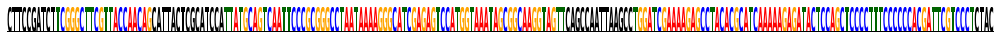

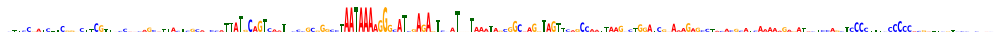

Test sequence 1:


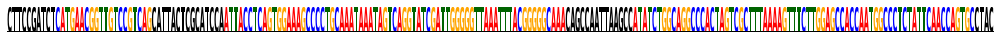

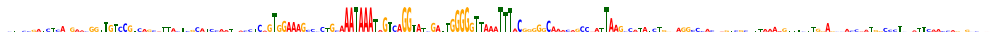

Test sequence 2:


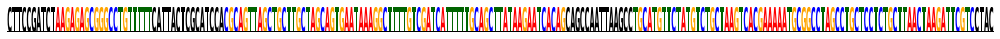

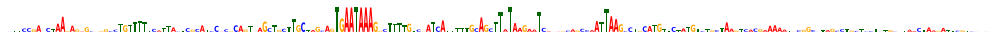

Test sequence 3:


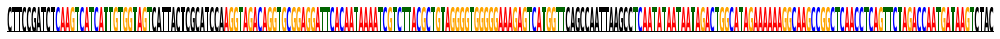

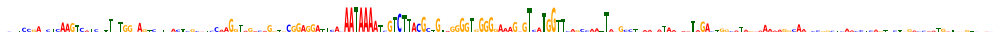

Test sequence 4:


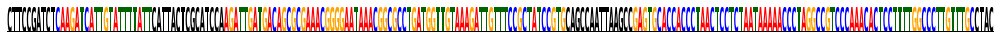

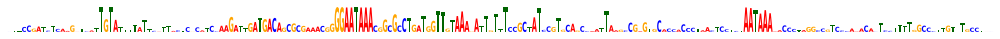

Test sequence 5:


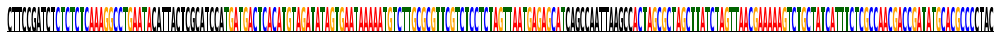

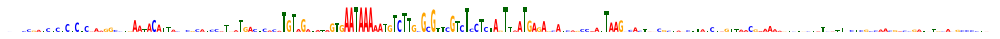

Test sequence 6:


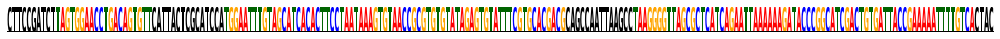

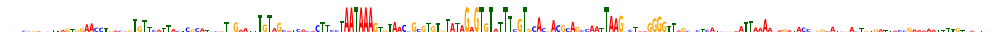

Test sequence 7:


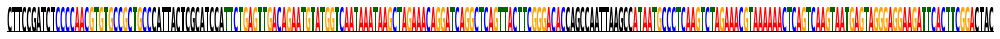

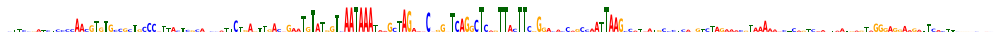

Test sequence 8:


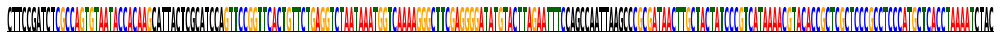

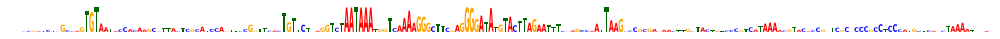

Test sequence 9:


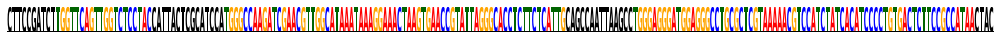

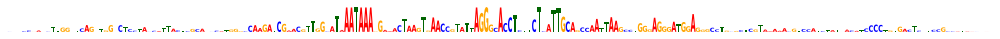

In [13]:
#Visualize a few perturbations

encoder = isol.OneHotEncoder(205)

score_clip = 0.5

for plot_i in range(0, 10) :

    print("Test sequence " + str(plot_i) + ":")

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205)
    plot_importance_scores(importance_scores_test[plot_i, 0, :, :].T, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)


In [20]:
#Save predicted importance scores

model_name = "perturbation_" + dataset_name

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [14]:
#Save predicted importance scores

model_name = "perturbation_" + dataset_name

np.save(model_name + "_importance_scores_test_signed", importance_scores_test_signed)
